In [1]:
# %matplotlib widget
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps
from utils.ephys_functions import*
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
import spikeinterface as si
from trimesh import load_mesh
import k3d
import matplotlib.cm as cm
from matplotlib.colors import Normalize

%matplotlib inline


In [24]:
def make_ccf_tbl(animal_id, annotator = 'zs', data_type = 'curated', save_to_session = True):
    annotation_dir = f'/root/capsule/data/alignment_{annotator}/{animal_id}'
    if os.path.exists(annotation_dir) == False:
        print('No annotation directory found')
    dorsal_edge_json = f'/root/capsule/data/dorsal_edges/{animal_id}_dorsal_edge_ccf.json'
    if os.path.exists(dorsal_edge_json):
        with open(dorsal_edge_json, 'r') as f:
            dorsal_edge_dict = json.load(f)
        # make into a dataframe
        dorsal_edge_df = pd.DataFrame(dorsal_edge_dict['xyz_picks'], columns=['x', 'y', 'z'])
        # make into a dataframe
        dorsal_edge_df['x'] = -dorsal_edge_df['x']/1000
        dorsal_edge_df['y'] = -dorsal_edge_df['y']/1000
        dorsal_edge_df['z'] = dorsal_edge_df['z']/1000

    # grab all session ids for this animal
    session_list_annotation = os.listdir(annotation_dir)
    date_list_annotation = [parseSessionID(session)[1] for session in session_list_annotation]
    session_assets = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
    session_list_all = session_assets['session_id']
    session_list_animal = [session for session in session_list_all if isinstance(session, str)]
    session_list_animal = [session for session in session_list_animal if animal_id in session]
    date_list_animal = [parseSessionID(session)[1] for session in session_list_animal]

    # for each date_list, find the corresponding session in session_list_all within 1 minute tolerance
    session_list = []
    for date in date_list_annotation:
        time_diff = [abs((date_list_animal_curr - date).total_seconds()) for date_list_animal_curr in date_list_animal]
        min_ind = np.argmin(time_diff)
        if time_diff[min_ind] < 60:
            session_list.append(session_list_animal[min_ind])
        else:
            session_list.append(None)
    
    unit_tbls = []
    probe_tbls = []
    for session_ind in range(len(session_list)):
        if session_list[session_ind] is None:
            print(f'No matching session found for {session_list_annotation[session_ind]}')
            unit_tbls.append(None)
            probe_tbls.append(None)    
        else:      
            print(f'Processing {session_list_annotation[session_ind]} matched to {session_list[session_ind]}')
            session = session_list[session_ind]
            session_annotation = session_list_annotation[session_ind]
            session_dir = session_dirs(session_id=session)
            if session_dir[f'postprocessed_dir_{data_type}'] is None:
                print(f'{data_type} data does not exist')
                unit_tbls.append(None)
                probe_tbls.append(None)
            else:    
                sorting_analyzer = si.load(session_dir[f'postprocessed_dir_{data_type}'], load_extensions=False)
                channel_locations = sorting_analyzer.get_channel_locations()
                unit_locations = sorting_analyzer.get_extension("unit_locations").get_data()
                channel_ids = sorting_analyzer.channel_ids
                channel_num = [int(chan[2:]) for chan in channel_ids]
                unit_loc_along_probe = unit_locations[:, 1]
                channel_loc_along_probe = channel_locations[:, 1]
                ccf_location_file = os.path.join(annotation_dir, session_annotation, 'ProbeA/ccf_channel_locations.json')
                ccf_dict = json.load(open(ccf_location_file, 'r'))
                ccf_df = pd.DataFrame(ccf_dict).T
                ccf_df.index = ccf_df.index.astype(str)  # make sure index is string
                ccf_df["channel_ind"] = ccf_df.index.str.split("_").str[1].astype(int)
                # filter by if channel_ind in channel_num
                ccf_df = ccf_df[ccf_df["channel_ind"].isin(channel_num)]
                ccf_df["loc_along_probe"] = channel_loc_along_probe
                # x for ml, y for ap, z for dv, with ccf origin and scale of mm
                xp = pd.to_numeric(ccf_df['loc_along_probe'], errors='raise').to_numpy()
                fp_x = pd.to_numeric(ccf_df['x'], errors='raise').to_numpy()
                fp_y = pd.to_numeric(ccf_df['y'], errors='raise').to_numpy()
                fp_z = pd.to_numeric(ccf_df['z'], errors='raise').to_numpy()

                unit_x_ccf = np.interp(unit_loc_along_probe, xp, fp_x)
                unit_y_ccf = np.interp(unit_loc_along_probe, xp, fp_y)
                unit_z_ccf = np.interp(unit_loc_along_probe, xp, fp_z)
                unit_ccf_df = pd.DataFrame({'unit_id': sorting_analyzer.unit_ids,
                                        'x_ccf': unit_x_ccf,
                                        'y_ccf': unit_y_ccf,
                                        'z_ccf': unit_z_ccf,
                                        'loc_along_probe': unit_loc_along_probe})
                unit_tbl = get_unit_tbl(session, data_type)
                unit_tbl = unit_tbl.drop(columns=['x_ccf', 'y_ccf', 'z_ccf'], errors="ignore")
                if save_to_session:
                    save_dir = os.path.join(session_dir[f'ephys_processed_dir_{data_type}'],'ccf_unit_locations.csv')
                    unit_ccf_df.to_csv(save_dir, index=False)
                unit_tbl_combined = unit_tbl.merge(unit_ccf_df, left_on='unit_id', right_on='unit_id', how='left')
                corr = unit_tbl_combined['corr_max_p'].values
                corr[np.isnan(corr)] = 1
                unit_tbl_combined = unit_tbl_combined[(unit_tbl_combined['decoder_label']!='artifact') & (corr>=0.80) & (unit_tbl_combined['lat_mean']>=0.004)]
                probe_tbls.append(ccf_df)
                unit_tbls.append(unit_tbl_combined)


    norm = Normalize(vmin=0, vmax=1)
    ml, ap, dv = 0, 1, 2
    planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
    if os.path.exists(dorsal_edge_json):
        with open(dorsal_edge_json, 'r') as f:
            dorsal_edge_dict = json.load(f)
        # make into a dataframe
        dorsal_edge_mat = dorsal_edge_df.values
    dorsal_edge_mat[:, 0] = dorsal_edge_mat[:, 0] - 0.04

    mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
    mesh_vertices = np.array(mesh.vertices)
    mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
    mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps

    # add the other side
    mesh_vertices_mm_flipped = mesh_vertices_lps.copy()
    mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]
    mesh_vertices_mm = np.vstack([mesh_vertices_lps, mesh_vertices_mm_flipped])
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges', 'Greys']

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    import matplotlib.cm as cm
    import matplotlib.patches as mpatches
    for plane, ax in zip(planes.keys(), axes):
        # Plot the mesh
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='gray', alpha=0.5, s=0.005,
            edgecolors=None
        )

        # plot dorsal edge if exists
        if os.path.exists(dorsal_edge_json):
            ax.scatter(
                dorsal_edge_mat[:, planes[plane][0]],
                dorsal_edge_mat[:, planes[plane][1]],
                color='b', s=1,
                edgecolors=None
            )

        # Plot the points
        for session_ind, session in enumerate(session_list):
            unit_tbl_combined = unit_tbls[session_ind]
            if unit_tbl_combined is None:
                continue
            unit_tbl_combined = unit_tbl_combined.sort_values(by="p_max", ascending=True)
            ccfs = unit_tbl_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
            bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
            ccfs = ccfs - bregma_LPS_mm

            # for probe
            ccfs_probe = probe_tbls[session_ind][['x', 'y', 'z']].values
            ccfs_probe = ccfs_probe - bregma_LPS_mm
            sc = ax.scatter(
                ccfs_probe[:, planes[plane][0]], 
                ccfs_probe[:, planes[plane][1]], 
                color='k', 
                s=5, 
                edgecolors=None,
                linewidth=0.2
                )

            sc = ax.scatter(
                ccfs[:, planes[plane][0]],
                ccfs[:, planes[plane][1]],
                c=unit_tbl_combined['p_max'],
                cmap=colormaps[session_ind],
                norm=Normalize(vmin=0, vmax=0.6),   # ← normalize color scale
                s=50, alpha=0.3,
                edgecolors=None, linewidths=1,
            )

            sort_ind = np.argsort(ccfs[:, dv])
            
            # ax.plot(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], color=cm.get_cmap(colormaps[session_ind])(1.0), label=session, linewidth=0.5)

        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

    # add the legend with brightest color for each session

    legend_handles = []
    for session_ind, session in enumerate(session_list):
        cmap = cm.get_cmap(colormaps[session_ind])
        brightest = cmap(1.0)  # lowest value = brightest in Reds/Greens/Blues
        patch = mpatches.Patch(color=brightest, label=session)
        legend_handles.append(patch)

    axes[1].legend(handles=legend_handles, title="Sessions")


    # axes[0].invert_yaxis()
    axes[0].invert_xaxis()
    # axes[2].invert_yaxis()


    plt.suptitle(f'{animal_id} units in CCF space with max(P(spike|laser)) color coding')
    plt.tight_layout()
    plt.savefig(f'/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator}_units_ccf_opto_tag.png', dpi=300)


    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges', 'Greys']

    # --- Load and preprocess mesh ---


    # Convert mesh to k3d mesh
    vertices = mesh_vertices_mm.astype(np.float32)
    indices = np.array(mesh.faces, dtype=np.uint32)

    plot = k3d.plot(camera_auto_fit=True)

    plt_mesh = k3d.mesh(
        vertices=vertices,
        indices=indices,
        color=0x888888,   # gray mesh
        opacity=0.1,
        wireframe=False,
        name='LC_right'
    )

    vertices_flipped = vertices.copy()
    vertices_flipped[:, ml] = -vertices_flipped[:, ml]

    plt_mesh_flipped = k3d.mesh(
        vertices=vertices_flipped,
        indices=indices,
        color=0x888888,   # gray mesh
        opacity=0.1,
        wireframe=False,
        name='LC_left'
    )

    plot += plt_mesh
    plot += plt_mesh_flipped

    # add dorsal edge if exists
    if os.path.exists(dorsal_edge_json):
        plt_dorsal = k3d.points(
            positions=dorsal_edge_mat.astype(np.float32),
            point_size=0.02,
            color=0x0000FF,   # blue points
            shader="3d",
            name='Dorsal_edge'
        )
        plot += plt_dorsal

    # --- Add probes + units for each session ---
    for session_ind, session in enumerate(session_list):
        if unit_tbls[session_ind] is None:
            continue

        unit_tbl_combined = unit_tbls[session_ind].sort_values(by="p_max", ascending=True)

        # Units
        ccfs = unit_tbl_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
        ccfs = ccfs - bregma_LPS_mm

        # Probes
        ccfs_probe = probe_tbls[session_ind][['x', 'y', 'z']].values
        ccfs_probe = ccfs_probe - bregma_LPS_mm

        # Colormap based on p_max


        # Colormap based on p_max, normalized to 0–0.6
        norm = Normalize(vmin=0, vmax=0.6)
        cmap = cm.get_cmap(colormaps[session_ind])
        pmax_normalized = norm(unit_tbl_combined['p_max'].values)

        # Convert to RGB (0–255) and then to integer color codes
        colors_rgb = (cmap(pmax_normalized)[:, :3] * 255).astype(np.uint32)
        colors = (colors_rgb[:, 0] << 16) + (colors_rgb[:, 1] << 8) + colors_rgb[:, 2]

        # Units
        plt_units = k3d.points(
            positions=ccfs.astype(np.float32),
            point_size=0.05,
            colors=colors,
            opacity=0.4,
            shader="3d",
            name=f'Units_{session[9:]}'
        )
        plot += plt_units


        # Probes (black points)
        plt_probes = k3d.points(
            positions=ccfs_probe.astype(np.float32),
            point_size=0.02,
            color=0x000000,
            shader="3d",
            name=f'Probe_{session[9:]}'
        )
        plot += plt_probes
    # save a html file
    # --- Save interactive plot to HTML ---
    html_file = f'/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator}_units_ccf_plot.html'
    with open(html_file, 'w') as f:
        f.write(plot.get_snapshot())

    plot.display()

In [16]:
# assumes parseSessionID, session_dirs, get_unit_tbl, si, load_mesh, pir_to_lps exist
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.lines import Line2D

def _collect_ccf_for_annotator(
    animal_id: str,
    annotator: str = "zs",
    data_type: str = "curated",
    save_to_session: bool = True,
):
    """
    Do the same work as make_ccf_tbl but only up to generating
    per-session unit CCF tables. Returns dicts keyed by session_id.
    """
    annotation_dir = f"/root/capsule/data/alignment_{annotator}/{animal_id}"
    if not os.path.exists(annotation_dir):
        print(f"[{annotator}] No annotation directory found at {annotation_dir}")
        return {}, {}

    # All annotation session folders for this animal
    session_list_annotation = os.listdir(annotation_dir)
    date_list_annotation = [parseSessionID(session)[1] for session in session_list_annotation]

    # All sessions from session_assets, filter to this animal
    session_assets = pd.read_csv("/root/capsule/code/data_management/session_assets.csv")
    session_list_all = session_assets["session_id"]
    session_list_animal = [session for session in session_list_all if isinstance(session, str)]
    session_list_animal = [session for session in session_list_animal if animal_id in session]
    date_list_animal = [parseSessionID(session)[1] for session in session_list_animal]

    # Match annotation sessions to IBL sessions within 1 minute
    matched_sessions = []
    for date in date_list_annotation:
        time_diff = [abs((date_animal - date).total_seconds()) for date_animal in date_list_animal]
        min_ind = np.argmin(time_diff)
        if time_diff[min_ind] < 60:
            matched_sessions.append(session_list_animal[min_ind])
        else:
            matched_sessions.append(None)

    # Per-session dicts (keyed by IBL session_id)
    session_unit_tbls = {}
    session_probe_tbls = {}

    for idx, session in enumerate(matched_sessions):
        annot_session = session_list_annotation[idx]

        if session is None:
            print(f"[{annotator}] No matching session found for {annot_session}")
            continue

        print(f"[{annotator}] Processing {annot_session} → {session}")
        session_dir = session_dirs(session_id=session)

        if session_dir.get(f"postprocessed_dir_{data_type}") is None:
            print(f"[{annotator}] {data_type} data does not exist for {session}")
            continue

        # Load sorting analyzer and locations
        sorting_analyzer = si.load(session_dir[f"postprocessed_dir_{data_type}"], load_extensions=False)
        channel_locations = sorting_analyzer.get_channel_locations()
        unit_locations = sorting_analyzer.get_extension("unit_locations").get_data()
        channel_ids = sorting_analyzer.channel_ids
        channel_num = [int(chan[2:]) for chan in channel_ids]
        unit_loc_along_probe = unit_locations[:, 1]
        channel_loc_along_probe = channel_locations[:, 1]

        # Load annotator's CCF channel locations
        ccf_location_file = os.path.join(
            annotation_dir,
            annot_session,
            "ProbeA/ccf_channel_locations.json",
        )
        if not os.path.exists(ccf_location_file):
            print(f"[{annotator}] Missing CCF file: {ccf_location_file}")
            continue

        with open(ccf_location_file, "r") as f:
            ccf_dict = json.load(f)
        ccf_df = pd.DataFrame(ccf_dict).T
        ccf_df.index = ccf_df.index.astype(str)
        ccf_df["channel_ind"] = ccf_df.index.str.split("_").str[1].astype(int)

        # Keep only channels that exist in this recording
        ccf_df = ccf_df[ccf_df["channel_ind"].isin(channel_num)]
        ccf_df["loc_along_probe"] = channel_loc_along_probe

        # prepare interpolation
        xp = pd.to_numeric(ccf_df["loc_along_probe"], errors="raise").to_numpy()
        fp_x = pd.to_numeric(ccf_df["x"], errors="raise").to_numpy()
        fp_y = pd.to_numeric(ccf_df["y"], errors="raise").to_numpy()
        fp_z = pd.to_numeric(ccf_df["z"], errors="raise").to_numpy()

        unit_x_ccf = np.interp(unit_loc_along_probe, xp, fp_x)
        unit_y_ccf = np.interp(unit_loc_along_probe, xp, fp_y)
        unit_z_ccf = np.interp(unit_loc_along_probe, xp, fp_z)

        unit_ccf_df = pd.DataFrame(
            {
                "unit_id": sorting_analyzer.unit_ids,
                "x_ccf": unit_x_ccf,
                "y_ccf": unit_y_ccf,
                "z_ccf": unit_z_ccf,
                "loc_along_probe": unit_loc_along_probe,
            }
        )

        # Load unit_tbl and attach CCF
        unit_tbl = get_unit_tbl(session, data_type)
        unit_tbl = unit_tbl.drop(columns=["x_ccf", "y_ccf", "z_ccf"], errors="ignore")

        if save_to_session:
            save_path = os.path.join(
                session_dir[f"ephys_processed_dir_{data_type}"],
                f"ccf_unit_locations_{annotator}.csv",
            )
            unit_ccf_df.to_csv(save_path, index=False)

        unit_tbl_combined = unit_tbl.merge(unit_ccf_df, on="unit_id", how="left")

        # Same filtering as your original function
        corr = unit_tbl_combined["corr_max_p"].values
        corr[np.isnan(corr)] = 1
        unit_tbl_combined = unit_tbl_combined[
            (unit_tbl_combined["decoder_label"] != "artifact")
            & (corr >= 0.80)
            & (unit_tbl_combined["lat_mean"] >= 0.004)
        ]

        session_unit_tbls[session] = unit_tbl_combined
        session_probe_tbls[session] = ccf_df

    return session_unit_tbls, session_probe_tbls

def compare_ccf_annotators(
    animal_id: str,
    annotator_A: str = "zs",
    annotator_B: str = "test",
    data_type: str = "curated",
    savefig: bool = True,
):
    """
    Compare CCF unit locations between two annotators for the same animal.
    For units that exist in both annotators' tables (matched by unit_id & session),
    plot arrows from annotator_A → annotator_B in the 3 CCF planes.
    """

    # --- get CCF tables for each annotator ---
    units_A, probes_A = _collect_ccf_for_annotator(
        animal_id, annotator=annotator_A, data_type=data_type, save_to_session=False
    )
    units_B, probes_B = _collect_ccf_for_annotator(
        animal_id, annotator=annotator_B, data_type=data_type, save_to_session=False
    )

    common_sessions = sorted(set(units_A.keys()) & set(units_B.keys()))
    if not common_sessions:
        print("No common sessions with CCF data for both annotators.")
        return

    print(f"Common sessions: {common_sessions}")

    # --- dorsal edge (same for both annotators) ---
    dorsal_edge_json = f"/root/capsule/data/dorsal_edges/{animal_id}_dorsal_edge_ccf.json"
    dorsal_edge_mat = None
    if os.path.exists(dorsal_edge_json):
        with open(dorsal_edge_json, "r") as f:
            dorsal_edge_dict = json.load(f)
        dorsal_edge_df = pd.DataFrame(dorsal_edge_dict["xyz_picks"], columns=["x", "y", "z"])
        dorsal_edge_df["x"] = -dorsal_edge_df["x"] / 1000.0
        dorsal_edge_df["y"] = -dorsal_edge_df["y"] / 1000.0
        dorsal_edge_df["z"] = dorsal_edge_df["z"] / 1000.0
        dorsal_edge_mat = dorsal_edge_df.values
        dorsal_edge_mat[:, 0] = dorsal_edge_mat[:, 0] - 0.04  # your original shift

    # --- load CCF mesh ---
    mesh = load_mesh(
        "/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj"
    )
    mesh_vertices = np.array(mesh.vertices)
    mesh_vertices = (mesh_vertices - np.array([216, 18, 228])) * 25 / 1000.0
    mesh_vertices_lps = pir_to_lps(mesh_vertices)

    # add other hemisphere (mirror)
    ml, ap, dv = 0, 1, 2
    mesh_vertices_flipped = mesh_vertices_lps.copy()
    mesh_vertices_flipped[:, ml] = -mesh_vertices_flipped[:, ml]
    mesh_vertices_mm = np.vstack([mesh_vertices_lps, mesh_vertices_flipped])

    planes = {"sag": [ap, dv], "hor": [ml, ap], "cor": [ml, dv]}

    # Bregma offset in LPS mm (same as your original)
    bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # distinct colors per session
    sess_colors = cm.get_cmap("tab10")(np.linspace(0, 1, len(common_sessions)))

    all_displacements = []

    for ax, (plane_name, idx_pair) in zip(axes, planes.items()):
        idx_x, idx_y = idx_pair

        # Mesh background
        ax.scatter(
            mesh_vertices_mm[:, idx_x],
            mesh_vertices_mm[:, idx_y],
            color="gray",
            alpha=0.4,
            s=0.005,
            edgecolors="none",
        )

        # dorsal edge
        if dorsal_edge_mat is not None:
            ax.scatter(
                dorsal_edge_mat[:, idx_x],
                dorsal_edge_mat[:, idx_y],
                color="b",
                s=1,
                edgecolors="none",
            )

        for s_i, session in enumerate(common_sessions):
            dfA = units_A[session]
            dfB = units_B[session]

            # match by unit_id
            pairs = dfA[["unit_id", "x_ccf", "y_ccf", "z_ccf"]].merge(
                dfB[["unit_id", "x_ccf", "y_ccf", "z_ccf"]],
                on="unit_id",
                suffixes=("_A", "_B"),
            )

            if pairs.empty:
                print(f"No overlapping units for session {session}")
                continue

            coordsA = pairs[["x_ccf_A", "y_ccf_A", "z_ccf_A"]].values - bregma_LPS_mm
            coordsB = pairs[["x_ccf_B", "y_ccf_B", "z_ccf_B"]].values - bregma_LPS_mm

            xA = coordsA[:, idx_x]
            yA = coordsA[:, idx_y]
            xB = coordsB[:, idx_x]
            yB = coordsB[:, idx_y]

            dx = xB - xA
            dy = yB - yA

            # store 3D displacement for summary
            disp_3d = np.linalg.norm(coordsB - coordsA, axis=1)
            all_displacements.append(disp_3d)

            color_sess = sess_colors[s_i]

            # start points (annotator A)
            ax.scatter(
                xA,
                yA,
                s=10,
                facecolors="none",
                edgecolors=color_sess,
                linewidths=0.7,
                alpha=0.7,
            )

            # end points (annotator B)
            ax.scatter(
                xB,
                yB,
                s=10,
                c=color_sess,
                alpha=0.7,
                marker="x",
            )

            # arrow A → B
            ax.quiver(
                xA,
                yA,
                dx,
                dy,
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.002,
                alpha=0.4,
                color=color_sess,
            )

        ax.set_xlabel(idx_x)
        ax.set_ylabel(idx_y)
        ax.set_aspect("equal")
        ax.set_title(f"{plane_name} plane")

    # mimic your original invert
    axes[0].invert_xaxis()

    # Legend for annotators + sessions
    session_handles = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="none",
            markerfacecolor="none",
            markeredgecolor=sess_colors[i],
            label=f"Session {i+1}: {sess}",
        )
        for i, sess in enumerate(common_sessions)
    ]

    annot_handles = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="k",
            markerfacecolor="none",
            label=f"{annotator_A} (start)",
        ),
        Line2D(
            [0],
            [0],
            marker="x",
            color="k",
            label=f"{annotator_B} (end)",
        ),
    ]

    axes[1].legend(handles=session_handles + annot_handles, fontsize=8)

    plt.suptitle(
        f"{animal_id}: CCF unit locations\nArrows from {annotator_A} → {annotator_B}",
        fontsize=16,
    )
    plt.tight_layout()

    if savefig:
        out_png = f"/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator_A}_to_{annotator_B}_units_ccf_arrows.png"
        plt.savefig(out_png, dpi=300)
        print(f"Saved comparison figure to: {out_png}")

    # summarize displacement
    if all_displacements:
        all_disp = np.concatenate(all_displacements)
        print(
            f"Displacement stats (A→B) in 3D mm for {animal_id}: "
            f"mean={all_disp.mean():.3f}, median={np.median(all_disp):.3f}, "
            f"max={all_disp.max():.3f}, n={len(all_disp)}"
        )

    return

def compare_ccf_between_annotators_3D(animal_id, annotator_A="zs", annotator_B="jx", data_type="curated"):
    print(f"\n===== Comparing annotators {annotator_A} vs {annotator_B} for {animal_id} =====")

    # Load CCF tables
    A_units, A_probes = _collect_ccf_for_annotator(animal_id, annotator_A, data_type)
    B_units, B_probes = _collect_ccf_for_annotator(animal_id, annotator_B, data_type)

    # Find sessions annotated by BOTH
    common_sessions = sorted(set(A_units.keys()) & set(B_units.keys()))
    if not common_sessions:
        print("No common sessions between annotators!")
        return None

    print("Common sessions:", common_sessions)

    # Load dorsal edge
    dorsal_edge_json = f"/root/capsule/data/dorsal_edges/{animal_id}_dorsal_edge_ccf.json"
    dorsal_edge = None
    if os.path.exists(dorsal_edge_json):
        df = pd.DataFrame(json.load(open(dorsal_edge_json))["xyz_picks"],
                          columns=["x","y","z"])
        df["x"] = -df["x"]/1000
        df["y"] = -df["y"]/1000
        df["z"] = df["z"]/1000
        dorsal_edge = df.values
        dorsal_edge[:,0] -= 0.04

    # Load CCF mesh
    mesh = load_mesh("/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj")
    V = np.array(mesh.vertices)
    V = (V - np.array([216,18,228]))*25/1000
    V = pir_to_lps(V)

    # mirror
    ml, ap, dv = 0,1,2
    Vflip = V.copy()
    Vflip[:,ml] = -Vflip[:,ml]
    Vall = np.vstack([V, Vflip])

    # Bregma shift
    bregma = np.array([-5.74, 5.4, -0.45])

    # ===============================================
    # 2D COMPARISON PLOT
    # ===============================================
    planes = {"sag":[ap,dv], "hor":[ml,ap], "cor":[ml,dv]}

    fig, axes = plt.subplots(1,3,figsize=(24,8))
    cmap_sess = cm.get_cmap('tab10')(np.linspace(0,1,len(common_sessions)))

    all_disp = []

    for ax, (pname, idx) in zip(axes, planes.items()):
        i,j = idx

        # mesh background
        ax.scatter(Vall[:,i], Vall[:,j], c='gray', s=0.003, alpha=0.3, edgecolors='none')

        # dorsal edge
        if dorsal_edge is not None:
            ax.scatter(dorsal_edge[:,i], dorsal_edge[:,j], c='blue', s=1, edgecolors='none')

        # sessions
        for si, session in enumerate(common_sessions):
            U_A = A_units[session]
            U_B = B_units[session]

            merged = U_A.merge(U_B, on="unit_id", suffixes=("_A","_B"))
            if merged.empty:
                continue

            Apts = merged[["x_ccf_A","y_ccf_A","z_ccf_A"]].values - bregma
            Bpts = merged[["x_ccf_B","y_ccf_B","z_ccf_B"]].values - bregma

            xA, yA = Apts[:,i], Apts[:,j]
            xB, yB = Bpts[:,i], Bpts[:,j]

            dx = xB - xA
            dy = yB - yA

            # accumulate displacement
            disp3d = np.linalg.norm(Bpts - Apts, axis=1)
            all_disp.append(disp3d)

            col = cmap_sess[si]

            # A positions
            ax.scatter(xA, yA, s=10, facecolors='none', edgecolors=col, linewidths=0.8)
            # B positions
            ax.scatter(xB, yB, s=12, c=col, marker='x')
            # arrows
            ax.quiver(xA,yA,dx,dy, angles='xy', scale_units='xy', scale=1, width=0.002,
                       color=col, alpha=0.6)

        ax.set_title(pname)
        ax.set_xlabel(i)
        ax.set_ylabel(j)
        ax.set_aspect('equal')

    axes[0].invert_xaxis()
    plt.suptitle(f"{animal_id}: Annotator comparison {annotator_A} → {annotator_B}")
    out2d = f"/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator_A}_to_{annotator_B}_2D.png"
    plt.savefig(out2d, dpi=300)
    print("Saved 2D comparison:", out2d)

    # ===============================================
    # 3D INTERACTIVE PLOT
    # ===============================================
    plot3d = k3d.plot(camera_auto_fit=True)

    # meshes
    faces = np.array(mesh.faces, dtype=np.uint32)

    plot3d += k3d.mesh(vertices=V.astype(np.float32), indices=faces,
                       color=0x999999, opacity=0.1, name='mesh_R')
    plot3d += k3d.mesh(vertices=Vflip.astype(np.float32), indices=faces,
                       color=0x999999, opacity=0.1, name='mesh_L')

    # dorsal edge
    if dorsal_edge is not None:
        plot3d += k3d.points(positions=dorsal_edge.astype(np.float32),
                             point_size=0.02, color=0x0000FF, shader='3d')

    color_A = 0x3366FF
    color_B = 0xFF3333
    color_arrow = 0xAAAAAA

    for session in common_sessions:
        U_A = A_units[session]
        U_B = B_units[session]

        merged = U_A.merge(U_B, on="unit_id", suffixes=("_A","_B"))
        if merged.empty:
            continue

        Apts = (merged[["x_ccf_A","y_ccf_A","z_ccf_A"]].values - bregma).astype(np.float32)
        Bpts = (merged[["x_ccf_B","y_ccf_B","z_ccf_B"]].values - bregma).astype(np.float32)

        # plot points
        plot3d += k3d.points(Apts, point_size=0.05, color=color_A, shader='3d', opacity=0.5)
        plot3d += k3d.points(Bpts, point_size=0.05, color=color_B, shader='3d', opacity=0.5)

        # plot arrows
        for a,b in zip(Apts,Bpts):
            AB = np.vstack([a,b]).astype(np.float32)
            plot3d += k3d.line(AB, color=color_arrow, width=0.002)

    out3d = f"/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator_A}_to_{annotator_B}_3D.html"
    with open(out3d, "w") as f:
        f.write(plot3d.get_snapshot())
    print("Saved 3D comparison:", out3d)

    plot3d.display()

    # ===============================================
    # displacement summary
    # ===============================================
    if all_disp:
        all_disp = np.concatenate(all_disp)
        print(f"Displacement stats (mm): mean={all_disp.mean():.4f}, "
              f"median={np.median(all_disp):.4f}, max={all_disp.max():.4f}, n={len(all_disp)}")
    
    return all_disp



Processing behavior_751004_2024-12-21_13-28-24 matched to behavior_751004_2024-12-21_13-28-28
Processing behavior_751004_2024-12-20_13-26-07 matched to behavior_751004_2024-12-20_13-26-11


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


Processing behavior_751004_2024-12-19_11-50-31 matched to behavior_751004_2024-12-19_11-50-37


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


Processing behavior_751004_2024-12-23_14-19-57 matched to behavior_751004_2024-12-23_14-20-03


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(
/tmp/ipykernel_32087/1138491674.py:180: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[session_ind])
/tmp/ipykernel_32087/1138491674.py:264: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[session_ind])
/tmp/ipykernel_32087/1138491674.py:264: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotli

Output()

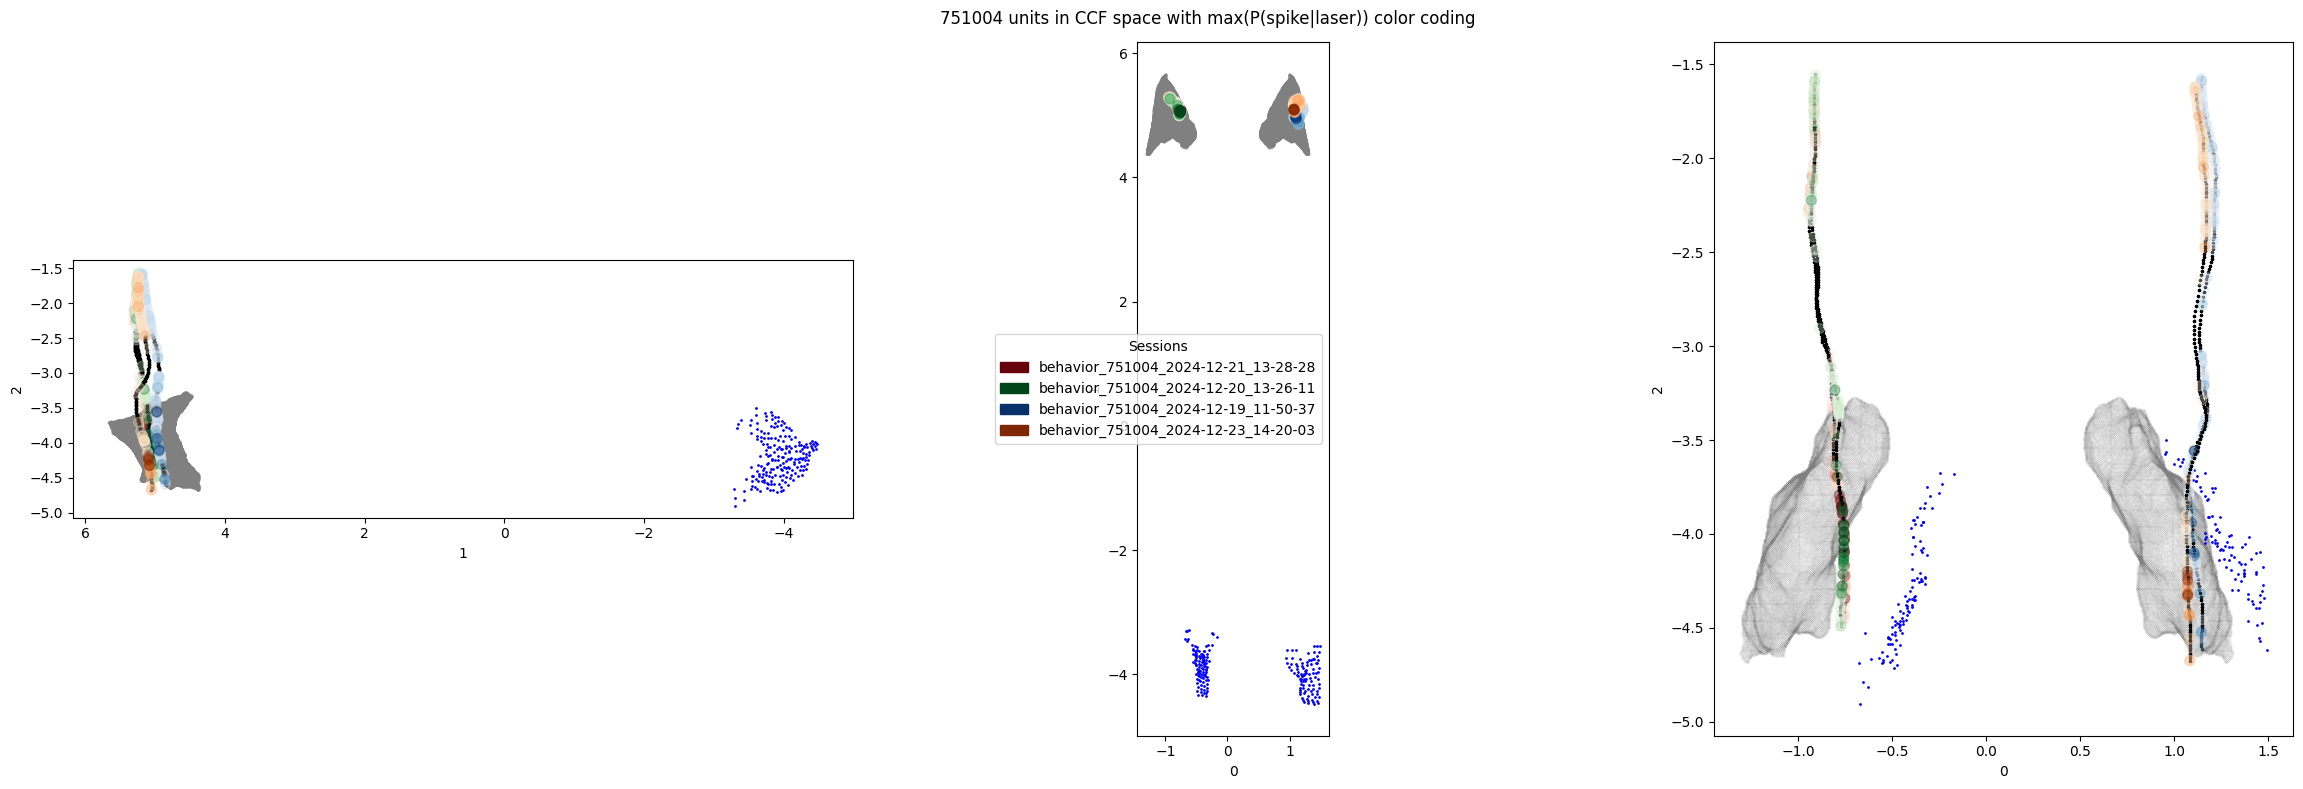

In [25]:
make_ccf_tbl('751004', annotator='fix', data_type='curated', save_to_session=False)

[test] Processing behavior_781166_2025-05-16_14-16-29 → behavior_781166_2025-05-16_14-16-34


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[test] Processing behavior_781166_2025-05-14_14-18-24 → behavior_781166_2025-05-14_14-18-28


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[test] Processing behavior_781166_2025-05-15_14-20-48 → behavior_781166_2025-05-15_14-20-51


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[test] Processing behavior_781166_2025-05-13_14-04-22 → behavior_781166_2025-05-13_14-04-27


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[fix] Processing behavior_781166_2025-05-16_14-16-29 → behavior_781166_2025-05-16_14-16-34


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[fix] Processing behavior_781166_2025-05-14_14-18-24 → behavior_781166_2025-05-14_14-18-28


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[fix] Processing behavior_781166_2025-05-15_14-20-48 → behavior_781166_2025-05-15_14-20-51


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[fix] Processing behavior_781166_2025-05-13_14-04-22 → behavior_781166_2025-05-13_14-04-27


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


Common sessions: ['behavior_781166_2025-05-13_14-04-27', 'behavior_781166_2025-05-14_14-18-28', 'behavior_781166_2025-05-15_14-20-51', 'behavior_781166_2025-05-16_14-16-34']


/tmp/ipykernel_32087/1692533061.py:204: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sess_colors = cm.get_cmap("tab10")(np.linspace(0, 1, len(common_sessions)))
/tmp/ipykernel_32087/1692533061.py:275: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_32087/1692533061.py:275: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2

Saved comparison figure to: /root/capsule/scratch/combined/ccf_maps/781166_test_to_fix_units_ccf_arrows.png
Displacement stats (A→B) in 3D mm for 781166: mean=0.169, median=0.140, max=0.458, n=1248

===== Comparing annotators test vs fix for 781166 =====
[test] Processing behavior_781166_2025-05-16_14-16-29 → behavior_781166_2025-05-16_14-16-34


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[test] Processing behavior_781166_2025-05-14_14-18-24 → behavior_781166_2025-05-14_14-18-28


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[test] Processing behavior_781166_2025-05-15_14-20-48 → behavior_781166_2025-05-15_14-20-51


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[test] Processing behavior_781166_2025-05-13_14-04-22 → behavior_781166_2025-05-13_14-04-27


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[fix] Processing behavior_781166_2025-05-16_14-16-29 → behavior_781166_2025-05-16_14-16-34


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[fix] Processing behavior_781166_2025-05-14_14-18-24 → behavior_781166_2025-05-14_14-18-28


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[fix] Processing behavior_781166_2025-05-15_14-20-48 → behavior_781166_2025-05-15_14-20-51


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


[fix] Processing behavior_781166_2025-05-13_14-04-22 → behavior_781166_2025-05-13_14-04-27


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.1 is recommended
  warnings.warn(


Common sessions: ['behavior_781166_2025-05-13_14-04-27', 'behavior_781166_2025-05-14_14-18-28', 'behavior_781166_2025-05-15_14-20-51', 'behavior_781166_2025-05-16_14-16-34']


/tmp/ipykernel_32087/1692533061.py:410: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_sess = cm.get_cmap('tab10')(np.linspace(0,1,len(common_sessions)))
/tmp/ipykernel_32087/1692533061.py:451: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xB, yB, s=12, c=col, marker='x')
/tmp/ipykernel_32087/1692533061.py:451: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* key

Saved 2D comparison: /root/capsule/scratch/combined/ccf_maps/781166_test_to_fix_2D.png
Saved 3D comparison: /root/capsule/scratch/combined/ccf_maps/781166_test_to_fix_3D.html


Output()

Displacement stats (mm): mean=0.1691, median=0.1401, max=0.4578, n=1248


array([0.06307609, 0.06461407, 0.06175581, ..., 0.37631057, 0.42883681,
       0.37353129])

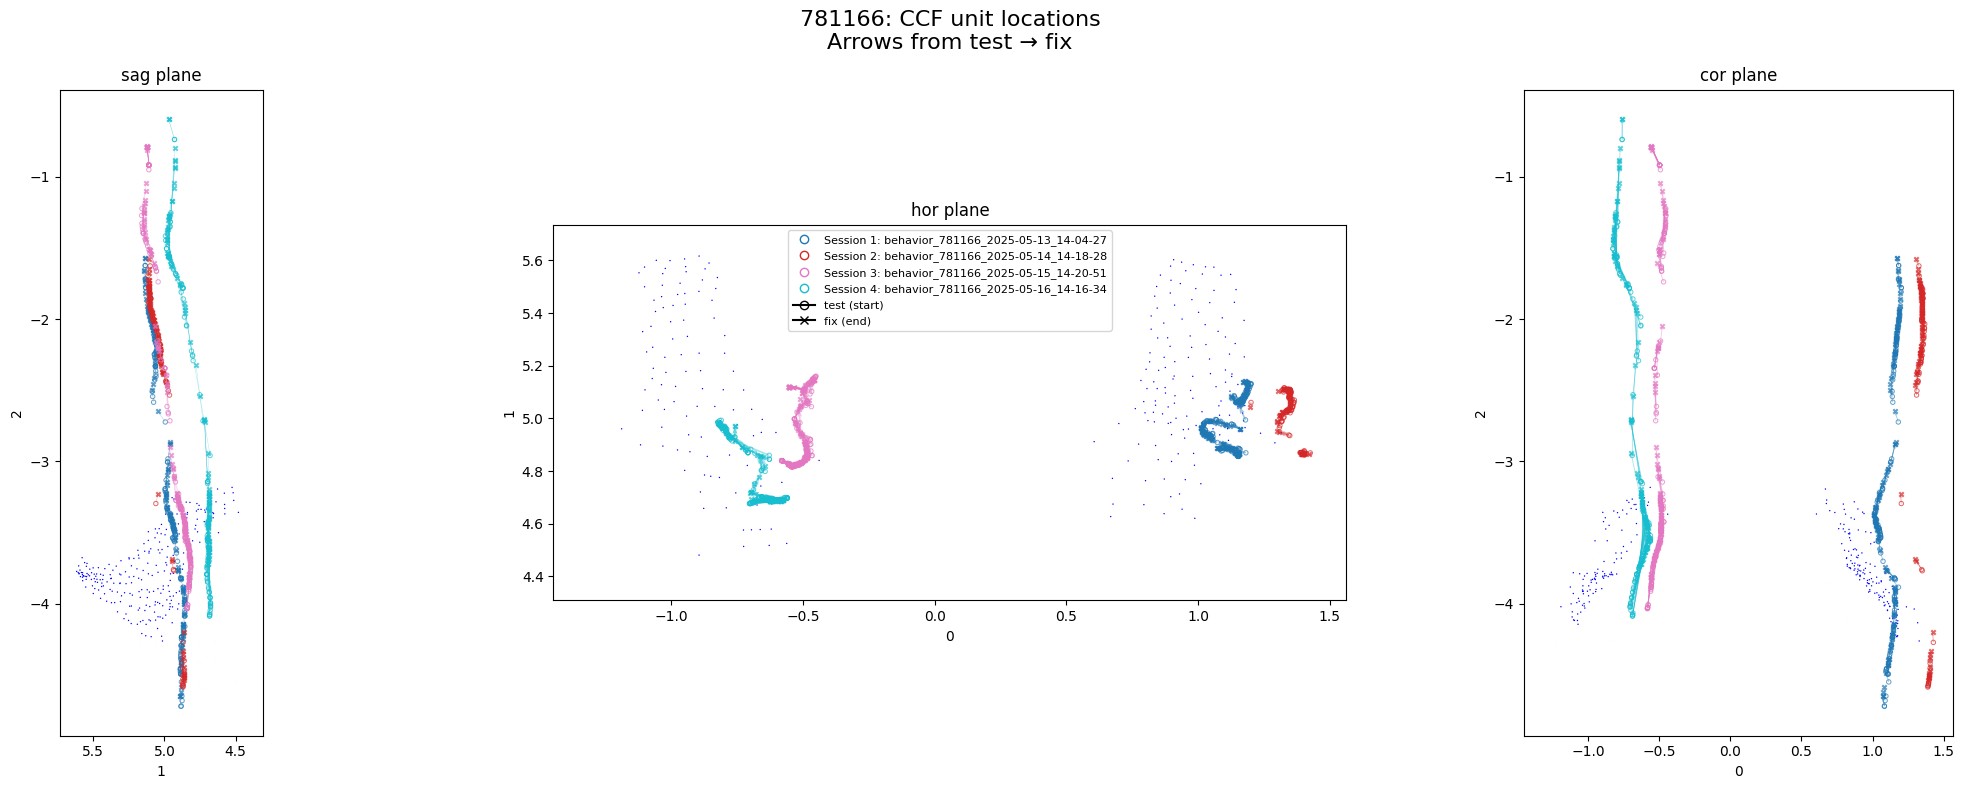

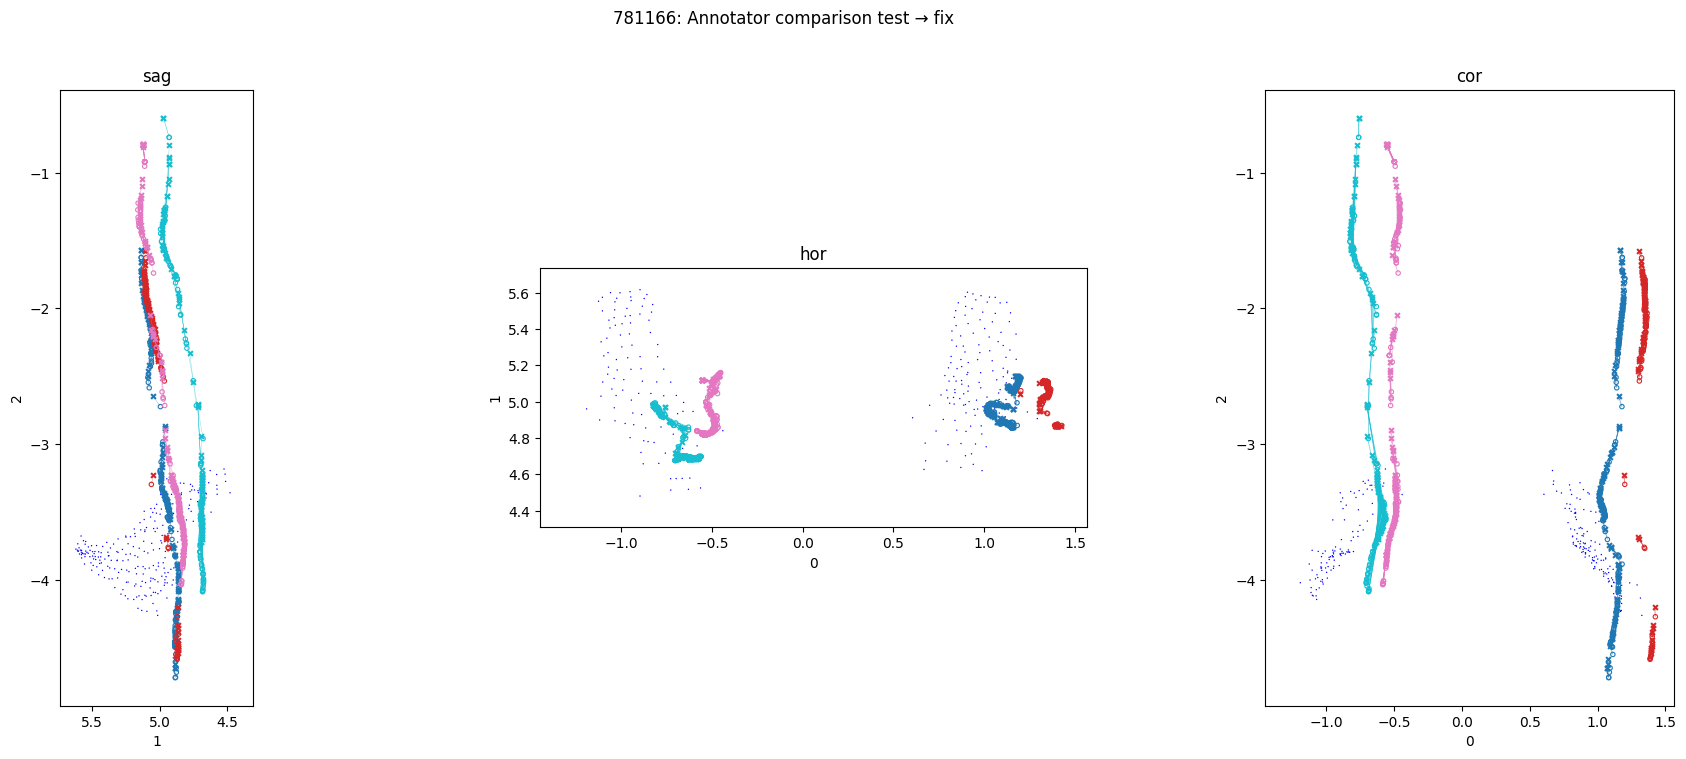

In [21]:
compare_ccf_annotators(animal_id='781166', annotator_A='test', annotator_B='fix', data_type='curated', savefig=True)
compare_ccf_between_annotators_3D(animal_id='781166', annotator_A='test', annotator_B='fix', data_type='curated')

In [3]:
txt_file = "/root/capsule/code/data_management/animal_ids.txt"

with open(txt_file) as f:
    animal_ids = [line.strip() for line in f if line.strip()]

for animal_id in animal_ids:
    make_ccf_tbl(animal_id, annotator='test', data_type='curated', save_to_session=True)
    

Processing behavior_782394_2025-04-23_10-51-14 matched to behavior_782394_2025-04-23_10-51-17


KeyboardInterrupt: 

In [4]:
# plot all session with p_response in space
txt_file = "/root/capsule/code/data_management/animal_ids.txt"

with open(txt_file) as f:
    animal_ids = [line.strip() for line in f if line.strip()]

all_brains = animal_ids
# all_brains = ['751766', '752014', '754897', '758017', '758018', '761038', '782394', '784803', '784806', '785956', '791691', '763590', '781166', '']
all_sessions = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')['session_id'].to_list()
all_sessions = [
    session for session in all_sessions 
    if isinstance(session, str) and any(brain in session for brain in all_brains)
]


# Plot combined opto units

In [6]:
txt_file = "/root/capsule/code/data_management/animal_ids.txt"

with open(txt_file) as f:
    animal_ids = [line.strip() for line in f if line.strip()]

In [19]:
all_ccfs_tbls = []
for session in all_sessions:
    unit_tbl = get_unit_tbl(session, data_type='curated')
    if unit_tbl is not None:
        corr = unit_tbl['corr_max_p'].values
        corr[np.isnan(corr)] = 1
        unit_tbl_filtered = unit_tbl[(unit_tbl['decoder_label']!='noise') & (unit_tbl['decoder_label']!='artifact') & (corr>0.85)]
        all_ccfs_tbls.append(unit_tbl_filtered)
all_ccfs_tbl = pd.concat(all_ccfs_tbls, ignore_index=True)

# --- Load and preprocess mesh ---
norm = Normalize(vmin=0, vmax=1)
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 229.5]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_lps[:, ml] = -mesh_vertices_lps[:, ml]
mesh_vertices_mm = mesh_vertices_lps
# add the other side
mesh_vertices_mm_flipped = mesh_vertices_lps.copy()
mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]
# mesh_vertices_mm = np.vstack([mesh_vertices_lps, mesh_vertices_mm_flipped])


No unit table found for behavior_751766_2025-02-15_12-08-11 in curated data.
No unit table found for behavior_784803_2025-07-03_13-55-13 in curated data.


/tmp/ipykernel_240656/2976536407.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_ccfs_tbl = pd.concat(all_ccfs_tbls, ignore_index=True)


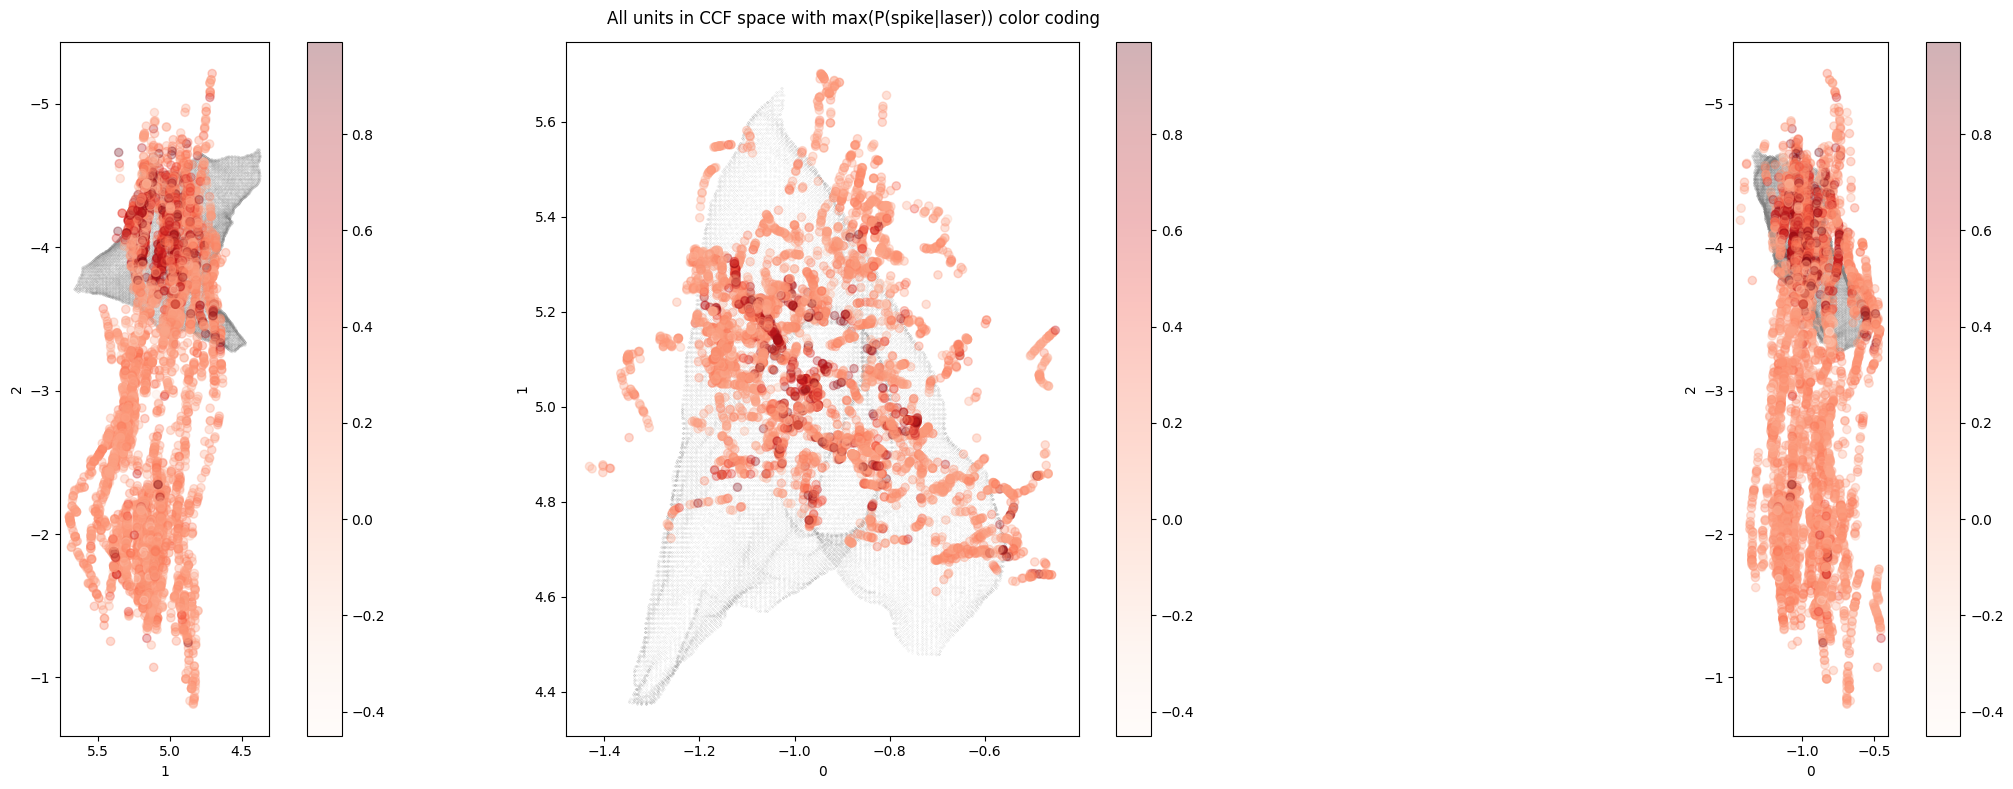

In [20]:

# Plot the points
ccfs = all_ccfs_tbl[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ccfs[ccfs[:, ml]>0, ml] = -ccfs[ccfs[:, ml]>0, ml]
ccf_units = ccfs.copy()
# mesh_vertices_mm = np.vstack([mesh_vertices_mm, mesh_vertices_mm_flipped])

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
import matplotlib.cm as cm
import matplotlib.patches as mpatches
for plane, ax in zip(planes.keys(), axes):
    # Plot the mesh
    ax.scatter(
        mesh_vertices_mm[:, planes[plane][0]],
        mesh_vertices_mm[:, planes[plane][1]],
        color='gray', alpha=0.5, s=0.005,
        edgecolors=None
    )

    sc = ax.scatter(
        ccfs[:, planes[plane][0]],
        ccfs[:, planes[plane][1]],
        c=all_ccfs_tbl['p_max'],
        cmap='Reds',
        s=35, alpha=0.3,
        edgecolors=None, linewidths=1,
    )
    # add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    # sort_ind = np.argsort(ccfs[:, dv])
    
    # ax.plot(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], color=cm.get_cmap(colormaps[session_ind])(1.0), label=session, linewidth=0.5)

    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')

# add the legend with brightest color for each session


axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[2].invert_yaxis()


plt.suptitle(f'All units in CCF space with max(P(spike|laser)) color coding')
plt.tight_layout()
plt.savefig(f'/root/capsule/scratch/combined/ccf_maps/all_units_ccf_opto_tag.png', dpi=300)
plt.show()


In [21]:
import numpy as np
import k3d
from matplotlib import cm
from matplotlib.colors import Normalize

# --- Normalize colormap based on p_max ---
norm = Normalize(vmin=all_ccfs_tbl['p_max'].min(), vmax=all_ccfs_tbl['p_max'].max())
cmap = cm.get_cmap('Reds')

# --- Load and convert mesh ---
# ml, ap, dv = 2, 0, 1
# mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
# mesh_vertices = np.array(mesh.vertices)
# mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)

# # Add mirrored hemisphere
# mesh_vertices_mm_flipped = mesh_vertices_mm.copy()
# mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]
# mesh_vertices_mm = np.vstack([mesh_vertices_mm, mesh_vertices_mm_flipped])

# #--- Prepare unit coordinates ---
# x_ccf = -all_ccfs_tbl['x_ccf'].values / 25 * 1000
# y_ccf = all_ccfs_tbl['y_ccf'].values / 25 * 1000
# z_ccf = -all_ccfs_tbl['z_ccf'].values / 25 * 1000
# ccfs = np.column_stack((y_ccf, z_ccf, x_ccf))
# ccfs = ccf_pts_convert_to_mm(ccfs)
# ccfs[ccfs[:, ml] > 0, ml] = -ccfs[ccfs[:, ml] > 0, ml]


# Colormap based on p_max
cmap = cm.get_cmap('Reds')
colors = (cmap(all_ccfs_tbl['p_max'].values)[:, :3] * 255).astype(np.uint32)
colors = (colors[:,0] << 16) + (colors[:,1] << 8) + colors[:,2]

# --- Create k3d plot ---
plot = k3d.plot(background_color=0xffffff, grid_visible=False, axes_helper=0)

# Add semi-transparent mesh (gray)
plot += k3d.points(
    positions=mesh_vertices_mm.astype(np.float32),
    colors=np.full(mesh_vertices_mm.shape[0], 0x808080, dtype=np.uint32),
    point_size=0.02,
    opacity=0.15
)

# Add dorsal edge (blue)
# dorsal_edge_mm = dorsal_edge_mat.copy()
# dorsal_edge_mm[:, ml] = -dorsal_edge_mm[:, ml]
# plot += k3d.points(
#     positions=dorsal_edge_mm.astype(np.float32),
#     colors=np.full(dorsal_edge_mm.shape[0], 0x0000ff, dtype=np.uint32),
#     point_size=0.05,
#     opacity=0.8
# )

# Add unit points, colored by p_max
plot += k3d.points(
    positions=ccfs.astype(np.float32),
    colors=colors,
    point_size=0.03,
    shader='3d'
)

# save as html
html_file = f'/root/capsule/scratch/combined/ccf_maps/all_units_ccf_plot.html'
with open(html_file, 'w') as f:
    f.write(plot.get_snapshot())
# --- Display ---
plot.display()


/tmp/ipykernel_240656/902312367.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')
/tmp/ipykernel_240656/902312367.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


Output()

# Plot dorsal edge

In [23]:
concat_dorsal_edge = []
for animal_id in animal_ids:
    dorsal_edge_json = f'/root/capsule/data/dorsal_edges/{animal_id}_dorsal_edge_ccf.json'
    if os.path.exists(dorsal_edge_json):
        with open(dorsal_edge_json, 'r') as f:
            dorsal_edge_dict = json.load(f)
        # make into a dataframe
        dorsal_edge_df = pd.DataFrame(dorsal_edge_dict['xyz_picks'], columns=['x', 'y', 'z'])
        # make into a dataframe
        dorsal_edge_df['x'] = -dorsal_edge_df['x']/1000
        dorsal_edge_df['y'] = -dorsal_edge_df['y']/1000
        dorsal_edge_df['z'] = dorsal_edge_df['z']/1000
        dorsal_edge_mat = dorsal_edge_df.values
        dorsal_edge_mat[:, 0] = dorsal_edge_mat[:, 0] - 0.04
        dorsal_edge_mat[:, ml]  = -np.abs(dorsal_edge_mat[:, ml])
        concat_dorsal_edge.append(dorsal_edge_mat)
ccfs = np.vstack(concat_dorsal_edge)
# --- Load and preprocess mesh ---
norm = Normalize(vmin=0, vmax=1)
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 229.5]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_lps[:, ml] = -mesh_vertices_lps[:, ml]
mesh_vertices_mm = mesh_vertices_lps
# add the other side
mesh_vertices_mm_flipped = mesh_vertices_lps.copy()
mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]

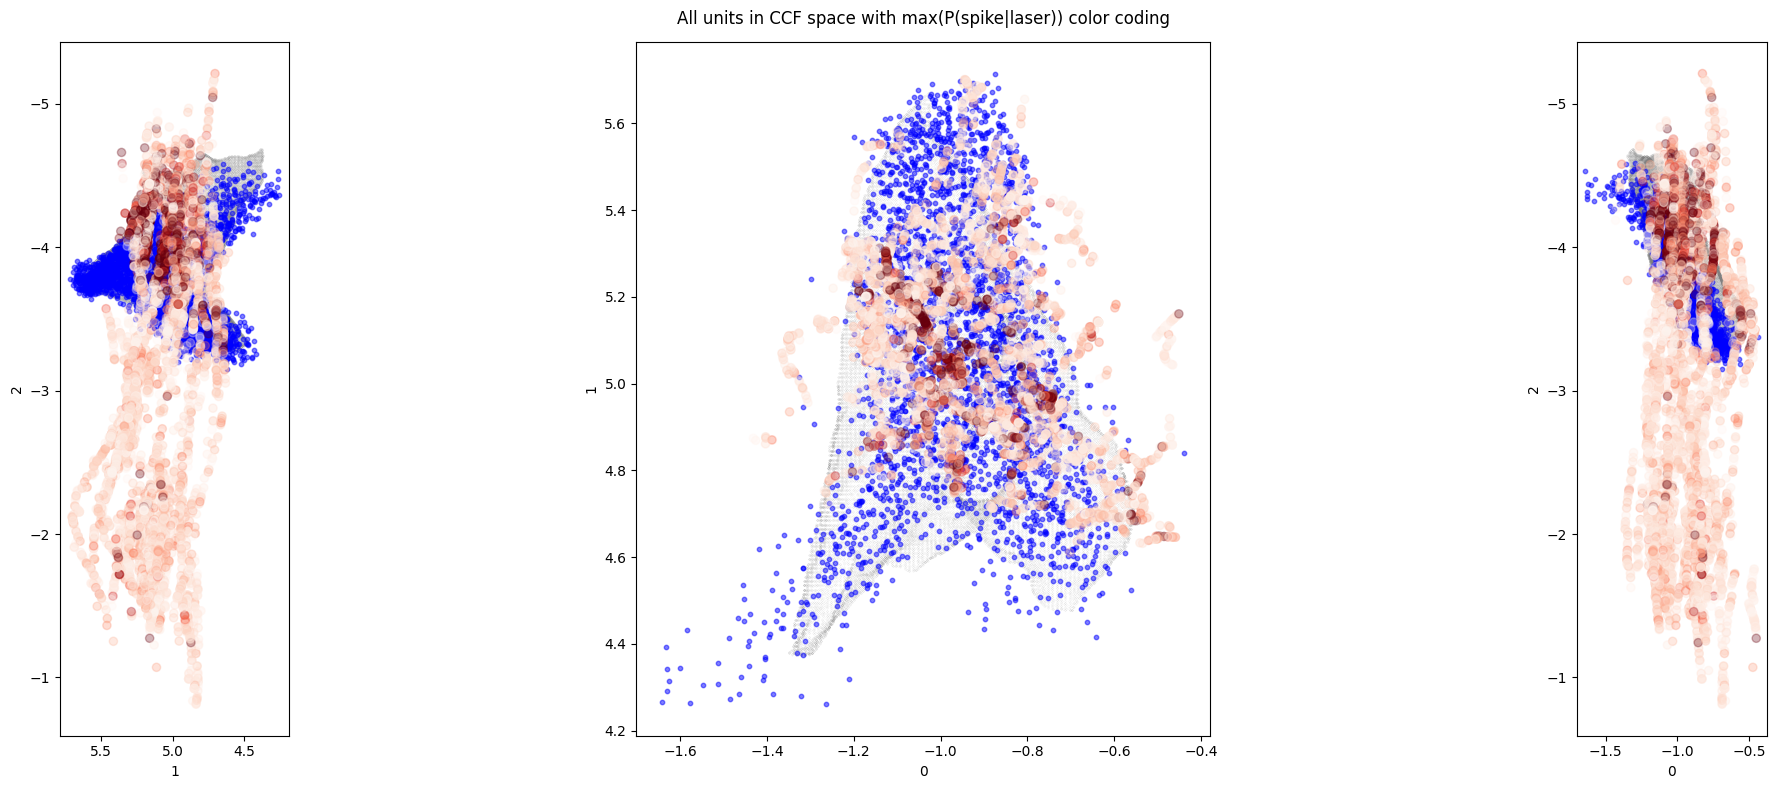

In [26]:
# Plot the points

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
import matplotlib.cm as cm
import matplotlib.patches as mpatches
for plane, ax in zip(planes.keys(), axes):
    # Plot the mesh
    ax.scatter(
        mesh_vertices_mm[:, planes[plane][0]],
        mesh_vertices_mm[:, planes[plane][1]],
        color='gray', alpha=0.5, s=0.005,
        edgecolors=None
    )

    sc = ax.scatter(
        ccfs[:, planes[plane][0]],
        ccfs[:, planes[plane][1]],
        color='b',
        s=10, alpha=0.5,
        edgecolors=None, linewidths=1,
    )

    sc = ax.scatter(
        ccf_units[:, planes[plane][0]],
        ccf_units[:, planes[plane][1]],
        c=all_ccfs_tbl['p_max'],
        cmap='Reds',
        norm=Normalize(vmin=0, vmax=0.6),
        s=35, alpha=0.3,
        edgecolors=None, linewidths=1,
    )
    
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')

# add the legend with brightest color for each session


axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[2].invert_yaxis()


plt.suptitle(f'All units in CCF space with max(P(spike|laser)) color coding')
plt.tight_layout()
plt.savefig(f'/root/capsule/scratch/combined/ccf_maps/dorsal_edge_LC.png', dpi=300)
plt.show()


In [27]:
import numpy as np
import k3d
from matplotlib import cm
from matplotlib.colors import Normalize

# --- Normalize colormap based on p_max ---

# --- Load and convert mesh ---
# ml, ap, dv = 2, 0, 1
# mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
# mesh_vertices = np.array(mesh.vertices)
# mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)

# # Add mirrored hemisphere
# mesh_vertices_mm_flipped = mesh_vertices_mm.copy()
# mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]
# mesh_vertices_mm = np.vstack([mesh_vertices_mm, mesh_vertices_mm_flipped])

# #--- Prepare unit coordinates ---
# x_ccf = -all_ccfs_tbl['x_ccf'].values / 25 * 1000
# y_ccf = all_ccfs_tbl['y_ccf'].values / 25 * 1000
# z_ccf = -all_ccfs_tbl['z_ccf'].values / 25 * 1000
# ccfs = np.column_stack((y_ccf, z_ccf, x_ccf))
# ccfs = ccf_pts_convert_to_mm(ccfs)
# ccfs[ccfs[:, ml] > 0, ml] = -ccfs[ccfs[:, ml] > 0, ml]



# --- Create k3d plot ---
plot = k3d.plot(background_color=0xffffff, grid_visible=False, axes_helper=0)

# Add semi-transparent mesh (gray)
plot += k3d.points(
    positions=mesh_vertices_mm.astype(np.float32),
    colors=np.full(mesh_vertices_mm.shape[0], 0x808080, dtype=np.uint32),
    point_size=0.02,
    opacity=0.15
)

# # add the other side
# plot += k3d.points(
#     positions=mesh_vertices_mm_flipped.astype(np.float32),
#     colors=np.full(mesh_vertices_mm_flipped.shape[0], 0x808080, dtype=np.uint32),
#     point_size=0.02,
#     opacity=0.15
# )

# Add dorsal edge (blue)
plot += k3d.points(
    positions=ccfs.astype(np.float32),
    point_size=0.01,
    # shader='3d'
)

# Add unit points, colored by p_max
plot += k3d.points(
    positions=ccf_units.astype(np.float32),
    colors=colors,
    point_size=0.03,
    shader='3d'
)

# save as html
html_file = f'/root/capsule/scratch/combined/ccf_maps/dorsal_edge_ccf_plot.html'
with open(html_file, 'w') as f:
    f.write(plot.get_snapshot())
# --- Display ---
plot.display()


Output()